In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib
import matplotlib.pyplot as plt

In [16]:
%matplotlib inline

plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('legend', title_fontsize=16)
plt.rc('legend', framealpha=0.0)
plt.rc('figure', titlesize=16)
plt.rc('lines', linewidth=3)
plt.rc('figure', figsize = [7,4])

In [6]:
def sanity_check_df(df):
    n = len(df["good_fit"])
    num_good_fit = np.sum(df["good_fit"])

def plot_graphs_one_figure(SEEDS, widths, template_title, LR, depth, plot_title, cifar_mode=False):
    if cifar_mode:
        plotting_conv_widths = [width[0] for width in widths]
    mpl.style.use('default')
    
    fig = plt.figure(figsize=(7,2))

#     ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
#     ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
#     ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
#     ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
#     ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

    ax1 = plt.subplot2grid(shape=(1,6), loc=(0,0), colspan=2)
    ax2 = plt.subplot2grid((1,6), (0,2), colspan=2,sharey=ax1)
    ax3 = plt.subplot2grid((1,6), (0,4), colspan=2,sharey=ax1)
    
    axes = [ax1, ax2, ax3]
    
    for num_ax, SEED in enumerate(SEEDS):
        ax_to_plot = axes[num_ax]
        mean_sampled_arr = []
        std_sampled_arr = []
        mean_trained_arr = []
        std_trained_arr = []

        rel_err_arr_sampled = []
        rel_err_arr_trained = []
        
        for width in widths:
            result_file = None
            if cifar_mode:
                convwidth = width[0]
                linwidth = width[1]
                result_file = pd.read_csv(f"../final_run_icml/{template_title}-0.000001-depth-{depth}-seed-{SEED}-linwidth-{linwidth}-convwidth-{convwidth}/result_summary_seed_{SEED}.csv")
            else:
                result_file = pd.read_csv(f"../final_run_icml/{template_title}-0.000001-depth-{depth}-seed-{SEED}-width-{width}/result_summary_seed_{SEED}.csv")
            sanity_check_df(result_file)

            filt = result_file["good_fit"] == 1
            length = len(filt)
            new_df = result_file[filt]
            
            sampled_model_accs = new_df["sampled_model_acc"]
            trained_model_accs = new_df["trained_model_acc"]

            assert (len(sampled_model_accs) == len(trained_model_accs))
            
            # sampled add
            mean_sampled = np.mean(sampled_model_accs)
            std_sampled = np.std(sampled_model_accs) / (np.sqrt(1.0 * len(sampled_model_accs)))
            
            # trained add
            mean_trained = np.mean(trained_model_accs)
            std_trained = np.std(trained_model_accs) / (np.sqrt(1.0 * len(trained_model_accs)))    

            mean_sampled_arr.append(mean_sampled)
            std_sampled_arr.append(std_sampled)
            mean_trained_arr.append(mean_trained)
            std_trained_arr.append(std_trained)
            
            # rel error add
            rel_err_samp_sum = 0.0
            rel_err_train_sum = 0.0
            for index, row in new_df.iterrows():
                margin_sampled = row["margin_sampled"]
                margin_trained = row["margin_trained"]
                train_err = row["error_trained"]
                
                # because both margin_sampled and margin_trained are of the form 1/gamma^2
                rel_error_denominator_is_sampled = train_err * np.sqrt(margin_sampled)
                rel_error_denominator_is_trained = train_err * np.sqrt(margin_trained)
                rel_err_samp_sum += rel_error_denominator_is_sampled
                rel_err_train_sum += rel_error_denominator_is_trained
        
            avg_rel_err_samp_sum = rel_err_samp_sum / len(new_df)
            avg_rel_err_train_sum = rel_err_train_sum / len(new_df)
            rel_err_arr_sampled.append(avg_rel_err_samp_sum)
            rel_err_arr_trained.append(avg_rel_err_train_sum)
        
        if cifar_mode:
            ax_to_plot.errorbar(plotting_conv_widths, mean_sampled_arr, std_sampled_arr, linestyle='-', marker='.', markersize=4, label='sampled')
            ax_to_plot.errorbar(plotting_conv_widths, mean_trained_arr, std_trained_arr, linestyle='-', marker='.', markersize=4, label='trained')
        else:
            ax_to_plot.errorbar(widths, mean_sampled_arr, std_sampled_arr, linestyle='-', marker='.', markersize=4, label='sampled')
            ax_to_plot.errorbar(widths, mean_trained_arr, std_trained_arr, linestyle='-', marker='.', markersize=4, label='trained')
        ax_to_plot.set_title(f"Seed {num_ax + 1}", fontsize=16)
        ax_to_plot.set_xlabel("Width", fontsize=16)
        ax_to_plot.tick_params(axis='both', labelsize=10)

        if num_ax != 0:
#             ax_to_plot.get_yaxis().set_visible(False)
            ax_to_plot.tick_params(labelleft=False)

#             ax_to_plot.get_yaxis().set_visible(False)
#     fig.supxlabel("Width")
    fig.supylabel("Test accuracy", verticalalignment="center", fontsize=16)
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize=16)

#     plt.legend(loc="upper left", bbox_to_anchor=(1.75, 2.56))
#     plt.suptitle(plot_title)
#     plt.subplots_adjust(wspace = 1.6, hspace=0.5, top=0.85)
    plt.subplots_adjust(left=0.15, wspace = 2.0, hspace=0.5, bottom=0.3)
    plt.tight_layout()
    plt.savefig(f"final_figures_v4/{template_title}.pdf")

    
def plot_rel_error_one_figure(SEEDS, widths, template_title, LR, depth, plot_title, cifar_mode=False):
    if cifar_mode:
        plotting_conv_widths = [width[0] for width in widths]
#     mpl.style.use('default')
    
#     fig = plt.figure(figsize=(20,10))

#     ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
#     ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
#     ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
#     ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
#     ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
    
#     axes = [ax1, ax2, ax3, ax4, ax5]
    
    global_max_rel_error = -1
    
    for num_ax, SEED in enumerate(SEEDS):
#         ax_to_plot = axes[num_ax]
        mean_sampled_arr = []
        std_sampled_arr = []
        mean_trained_arr = []
        std_trained_arr = []

        rel_err_arr_sampled = []
        rel_err_arr_trained = []
        
        for width in widths:
            result_file = None
            if cifar_mode:
                convwidth = width[0]
                linwidth = width[1]
                result_file = pd.read_csv(f"../final_run_icml/{template_title}-0.000001-depth-{depth}-seed-{SEED}-linwidth-{linwidth}-convwidth-{convwidth}/result_summary_seed_{SEED}.csv")
            else:
                result_file = pd.read_csv(f"../final_run_icml/{template_title}-0.000001-depth-{depth}-seed-{SEED}-width-{width}/result_summary_seed_{SEED}.csv")
            sanity_check_df(result_file)

            filt = result_file["good_fit"] == 1
            length = len(filt)
            new_df = result_file[filt]
            
            sampled_model_accs = new_df["rel_err_samp"]
            trained_model_accs = new_df["rel_err_train"]

            assert (len(sampled_model_accs) == len(trained_model_accs))
            
            max_rel_err = np.max(sampled_model_accs)
            if max_rel_err > global_max_rel_error:
                global_max_rel_error = max_rel_err
            
            # sampled add
            mean_sampled = np.mean(sampled_model_accs)
            std_sampled = np.std(sampled_model_accs) / (np.sqrt(1.0 * len(sampled_model_accs)))
            
            # trained add
            mean_trained = np.mean(trained_model_accs)
            std_trained = np.std(trained_model_accs) / (np.sqrt(1.0 * len(trained_model_accs)))    

            mean_sampled_arr.append(mean_sampled)
            std_sampled_arr.append(std_sampled)
            mean_trained_arr.append(mean_trained)
            std_trained_arr.append(std_trained)
            
        
#         if cifar_mode:
#             ax_to_plot.errorbar(plotting_conv_widths, mean_sampled_arr, std_sampled_arr, linestyle='None', marker='.', label='f_sampled', color="lightcoral")
#             ax_to_plot.errorbar(plotting_conv_widths, mean_trained_arr, std_trained_arr, linestyle='None', marker='.', label='f_trained')
#         else:
#             ax_to_plot.errorbar(widths, mean_sampled_arr, std_sampled_arr, linestyle='None', marker='.', label='f_sampled', color="lightcoral")
#             ax_to_plot.errorbar(widths, mean_trained_arr, std_trained_arr, linestyle='None', marker='.', label='f_trained')
#         ax_to_plot.set_title(f"Seed: {SEED}")
#     fig.supxlabel("Width", fontsize=30)
#     fig.supylabel("Relative Error ()", fontsize=30)
#     plt.legend(loc="upper left", bbox_to_anchor=(1.7, 2), prop={'size': 17})
#     plt.suptitle(plot_title, fontsize=30)
#     plt.subplots_adjust(wspace = 0.5)
    
    print(f"Max rel error across all seeds / architectures: {global_max_rel_error:.7f} ")


    

Max rel error across all seeds / architectures: 0.0000355 


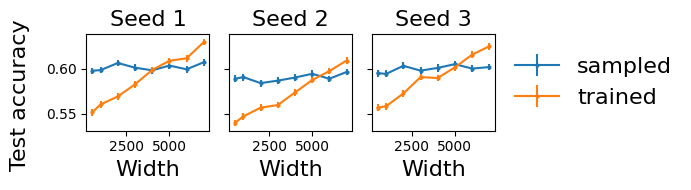

In [45]:


widths = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
# SEEDS = [160, 161, 162, 163, 164]
SEEDS = [160, 161, 162]
depth = 7
LR = 0.000001

plot_graphs_one_figure(SEEDS=SEEDS, widths=widths, template_title="mnist0v1", LR=LR, depth=depth, plot_title="MNIST 0 vs. 1")
plot_rel_error_one_figure(SEEDS=SEEDS, widths=widths, template_title="mnist0v1", LR=LR, depth=depth, plot_title="MNIST 0 vs. 1 (relative error)")



Max rel error across all seeds / architectures: 0.0000568 


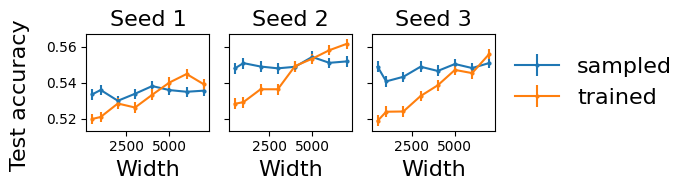

In [46]:
widths = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
# SEEDS = [165, 166, 167, 168, 169]
SEEDS = [165, 166, 167]
depth = 7
LR = 0.000001

plot_graphs_one_figure(SEEDS=SEEDS, widths=widths, template_title="mnist4v7", LR=LR, depth=depth, plot_title="MNIST 4 vs. 7")
plot_rel_error_one_figure(SEEDS=SEEDS, widths=widths, template_title="mnist4v7", LR=LR, depth=depth, plot_title="MNIST 4 vs. 7 (relative error)")


Max rel error across all seeds / architectures: 0.0000248 


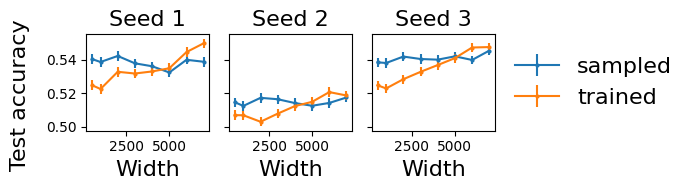

In [47]:
widths = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
# SEEDS = [170, 171, 172, 173, 174]
SEEDS = [170, 171, 172]
depth = 7
LR = 0.000001

plot_graphs_one_figure(SEEDS=SEEDS, widths=widths, template_title="mnist3v8", LR=LR, depth=depth, plot_title="MNIST 3 vs. 8")
plot_rel_error_one_figure(SEEDS=SEEDS, widths=widths, template_title="mnist3v8", LR=LR, depth=depth, plot_title="MNIST 3 vs. 8 (relative error)")



Max rel error across all seeds / architectures: 0.0002589 


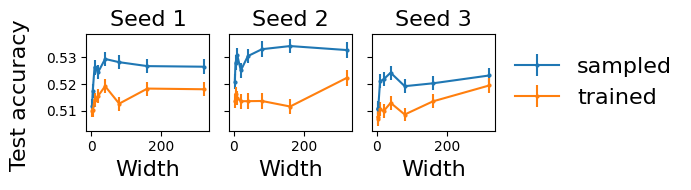

In [48]:
widths = [(3,500), (5,500), (10,500), (20,500), (40,500), (80,500), (160,500), (320, 500)]

# SEEDS = [175, 176, 177, 178, 179]
SEEDS = [175, 176, 177]
depth = 3
LR = 0.000001

# plot_graphs(SEEDS=SEEDS, widths=widths, template_title="mnist0v1", LR=LR, depth=depth)
plot_graphs_one_figure(SEEDS=SEEDS, widths=widths, template_title="cifar10dogvship", LR=LR, depth=depth, plot_title="CIFAR Dog vs. Ship", cifar_mode=True)

plot_rel_error_one_figure(SEEDS=SEEDS, widths=widths, template_title="cifar10dogvship", LR=LR, depth=depth, plot_title="CIFAR Dog vs. Ship (Relative Error)", cifar_mode=True)



In [4]:
# plotting just one for main paper
%matplotlib inline

plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('legend', title_fontsize=16)
plt.rc('legend', framealpha=0.0)
plt.rc('figure', titlesize=16)
plt.rc('lines', linewidth=3)
plt.rc('figure', figsize = [7,4])

def sanity_check_df(df):
    n = len(df["good_fit"])
    num_good_fit = np.sum(df["good_fit"])

def plot_graphs_just_one_for_paper(cifar_mode=False):
    if cifar_mode:
        plotting_conv_widths = [width[0] for width in widths]
#     mpl.style.use('default')
    
#     fig = plt.figure(figsize=(7,4))

    SEED = 160
    widths = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
    template_title = "mnist0v1"
    depth = 7
    LR = 0.000001
    mean_sampled_arr = []
    std_sampled_arr = []
    mean_trained_arr = []
    std_trained_arr = []

    rel_err_arr_sampled = []
    rel_err_arr_trained = []

    for width in widths:
        result_file = None
        if cifar_mode:
            convwidth = width[0]
            linwidth = width[1]
            result_file = pd.read_csv(f"../final_run_icml/{template_title}-0.000001-depth-{depth}-seed-{SEED}-linwidth-{linwidth}-convwidth-{convwidth}/result_summary_seed_{SEED}.csv")
        else:
            result_file = pd.read_csv(f"../final_run_icml/{template_title}-0.000001-depth-{depth}-seed-{SEED}-width-{width}/result_summary_seed_{SEED}.csv")
        sanity_check_df(result_file)

        filt = result_file["good_fit"] == 1
        length = len(filt)
        new_df = result_file[filt]

        sampled_model_accs = new_df["sampled_model_acc"]
        trained_model_accs = new_df["trained_model_acc"]

        assert (len(sampled_model_accs) == len(trained_model_accs))

        # sampled add
        mean_sampled = np.mean(sampled_model_accs)
        std_sampled = np.std(sampled_model_accs) / (np.sqrt(1.0 * len(sampled_model_accs)))

        # trained add
        mean_trained = np.mean(trained_model_accs)
        std_trained = np.std(trained_model_accs) / (np.sqrt(1.0 * len(trained_model_accs)))    

        mean_sampled_arr.append(mean_sampled)
        std_sampled_arr.append(std_sampled)
        mean_trained_arr.append(mean_trained)
        std_trained_arr.append(std_trained)

        # rel error add
        rel_err_samp_sum = 0.0
        rel_err_train_sum = 0.0
        for index, row in new_df.iterrows():
            margin_sampled = row["margin_sampled"]
            margin_trained = row["margin_trained"]
            train_err = row["error_trained"]

            # because both margin_sampled and margin_trained are of the form 1/gamma^2
            rel_error_denominator_is_sampled = train_err * np.sqrt(margin_sampled)
            rel_error_denominator_is_trained = train_err * np.sqrt(margin_trained)
            rel_err_samp_sum += rel_error_denominator_is_sampled
            rel_err_train_sum += rel_error_denominator_is_trained

        avg_rel_err_samp_sum = rel_err_samp_sum / len(new_df)
        avg_rel_err_train_sum = rel_err_train_sum / len(new_df)
        rel_err_arr_sampled.append(avg_rel_err_samp_sum)
        rel_err_arr_trained.append(avg_rel_err_train_sum)

    if cifar_mode:
        plt.errorbar(plotting_conv_widths, mean_sampled_arr, std_sampled_arr, linestyle='-', marker='.', label='sampled')
        plt.errorbar(plotting_conv_widths, mean_trained_arr, std_trained_arr, linestyle='-', marker='.', label='trained')
    else:
        plt.errorbar(widths, mean_sampled_arr, std_sampled_arr, linestyle='-', marker='.', label='sampled')
        plt.errorbar(widths, mean_trained_arr, std_trained_arr, linestyle='-', marker='.', label='trained')
    plt.xticks()
    plt.yticks()
#     plt.title(f"MNIST 0 vs. 1, Seed 1",fontsize=16)
    plt.xlabel("Width")
    plt.ylabel("Test accuracy")
    plt.legend(loc="upper left",frameon=False)
#     plt.suptitle(plot_title)
#     plt.subplots_adjust(wspace = 1.6, hspace=0.5, top=0.85)
#     plt.tight_layout(pad=0, w_pad=1.08)
    plt.tight_layout()
    plt.savefig(f"final_figures_v6/mnist_seed_160.pdf")
    
    

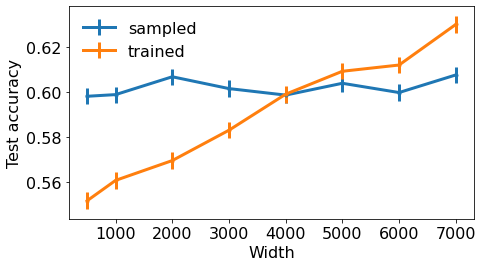

In [5]:
plot_graphs_just_one_for_paper()

In [342]:
# generating the tables

In [346]:
# mnist 0 vs. 1
temp_1 = [0.493249111725227, 0.9995262534544019, 0.9998420844848006, 0.9999210422424003, 0.9999210422424003, 0.9999210422424003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
temp_2 = [0.5858665613896565, 0.9998420844848006, 0.9999210422424003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
temp_3 = [0.4803000394788788, 0.9999210422424003, 0.9999210422424003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
temp_4 = [0.4498223450454007, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
temp_5 = [0.4851954204500592, 1.0, 0.9999210422424003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
temp_6 = [0.46466640347414134, 0.9999210422424003, 1.0, 1.0, 0.9999210422424003, 1.0, 0.9999210422424003, 0.9999210422424003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
temp_7 = [0.4958547177260166, 0.9999210422424003, 0.9998420844848006, 1.0, 0.9999210422424003, 0.9998420844848006, 0.9999210422424003, 0.9999210422424003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
temp_8 = [0.35238847216739044, 1.0, 0.9995262534544019, 0.9999210422424003, 0.9996841689696012, 0.9994472956968022, 0.9998420844848006, 0.9997631267272009, 0.9999210422424003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

full_list = [temp_1, temp_2, temp_3, temp_4, temp_5, temp_6, temp_7, temp_8]
lowest_acc = None
fixed_length = len(opt_1)
for lst in full_list:
    assert(len(lst) == fixed_length)
    end_train_acc = lst[-1]
    if (lowest_acc is None) or (end_train_acc < lowest_acc):
        lowest_acc = end_train_acc
        
print(f"Lowest train acc at end of training is: {lowest_acc}")



Lowest train acc at end of training is: 1.0


In [347]:
# mnist 3 vs. 8
opt_1 = [0.4783007845100985, 0.9818895009180437, 0.9932398597896845, 0.9968285761976298, 0.9985812051410449, 0.9985812051410449, 0.9992488733099649, 0.99933233183108, 0.9997496244366549, 0.99983308295777, 0.99983308295777, 0.999916541478885, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_2 = [0.46770155232849275, 0.9911533967618094, 0.9970789517609748, 0.99966616591554, 0.99983308295777, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_3 = [0.3681355366382908, 0.9954932398597897, 0.99899849774662, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_4 = [0.6044900684359873, 0.9969120347187448, 0.9997496244366549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_5 = [0.513770655983976, 0.9980804540143549, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999916541478885, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_6 = [0.4955766983809047, 0.9982473710565849, 0.99949924887331, 1.0, 1.0, 1.0, 1.0, 0.9997496244366549, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_7 = [0.6156735102653981, 0.9976631614087799, 0.999916541478885, 1.0, 1.0, 0.9997496244366549, 1.0, 0.999916541478885, 1.0, 0.999916541478885, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_8 = [0.5183608746453013, 0.9969954932398598, 1.0, 1.0, 1.0, 0.999582707394425, 0.99966616591554, 0.99966616591554, 0.999916541478885, 0.999916541478885, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

full_list = [opt_1, opt_2, opt_3, opt_4, opt_5, opt_6, opt_7, opt_8]
lowest_acc = None
fixed_length = len(opt_1)
for lst in full_list:
    assert(len(lst) == fixed_length)
    end_train_acc = lst[-1]
    if (lowest_acc is None) or (end_train_acc < lowest_acc):
        lowest_acc = end_train_acc
        
print(f"Lowest train acc at end of training is: {lowest_acc}")



Lowest train acc at end of training is: 1.0


In [348]:
# cifar 10 dog vs ship
opt_1 = [0.5149, 0.5996, 0.6281, 0.6417, 0.6529, 0.6585, 0.6662, 0.6725, 0.6792, 0.6859, 0.691, 0.6976, 0.7023, 0.7057, 0.7097, 0.7126, 0.7155, 0.7187, 0.7209, 0.7232, 0.7251, 0.7262, 0.7271, 0.7286, 0.73, 0.7304, 0.7307, 0.7312, 0.7321, 0.7323, 0.7332, 0.7335, 0.7343, 0.7347, 0.7349, 0.7354, 0.736, 0.7364, 0.7367, 0.737, 0.737, 0.737, 0.7371, 0.7372, 0.7374, 0.7378, 0.7378, 0.738, 0.738, 0.738, 0.7381]
opt_2 = [0.508, 0.5977, 0.6278, 0.6487, 0.6657, 0.6844, 0.6989, 0.7145, 0.7271, 0.7354, 0.7447, 0.7527, 0.7592, 0.7669, 0.7712, 0.7755, 0.7806, 0.7833, 0.7868, 0.7891, 0.7912, 0.7934, 0.7959, 0.7982, 0.7998, 0.8015, 0.8024, 0.804, 0.8049, 0.8062, 0.8071, 0.8076, 0.8086, 0.8095, 0.8101, 0.8106, 0.811, 0.811, 0.8113, 0.8117, 0.8117, 0.8118, 0.8119, 0.8122, 0.8125, 0.8124, 0.8123, 0.8124, 0.8124, 0.8122, 0.8121]
opt_3 = [0.4832, 0.6085, 0.6467, 0.6801, 0.7017, 0.7223, 0.7403, 0.7562, 0.7688, 0.7802, 0.7897, 0.7992, 0.8074, 0.8148, 0.8225, 0.828, 0.8331, 0.8377, 0.8412, 0.8448, 0.848, 0.8506, 0.8529, 0.8543, 0.8574, 0.859, 0.8599, 0.8613, 0.8628, 0.8629, 0.8635, 0.8644, 0.8653, 0.8659, 0.8663, 0.8669, 0.8674, 0.8679, 0.8681, 0.8688, 0.8688, 0.8693, 0.8698, 0.8702, 0.8705, 0.8712, 0.8712, 0.8712, 0.8713, 0.8713, 0.8713]
opt_4 = [0.4977, 0.6457, 0.689, 0.7182, 0.7431, 0.7672, 0.7878, 0.806, 0.8196, 0.8331, 0.8448, 0.8552, 0.8621, 0.8683, 0.876, 0.881, 0.886, 0.8896, 0.8939, 0.8983, 0.9019, 0.905, 0.9068, 0.9091, 0.9114, 0.9127, 0.9138, 0.9149, 0.9163, 0.9175, 0.9184, 0.9192, 0.9199, 0.9206, 0.9214, 0.9224, 0.9228, 0.9236, 0.9237, 0.9241, 0.9244, 0.925, 0.9253, 0.9254, 0.9256, 0.9258, 0.9258, 0.9259, 0.9261, 0.9263, 0.9265]
opt_5 = [0.5242, 0.661, 0.7138, 0.7484, 0.778, 0.8087, 0.8353, 0.8562, 0.8748, 0.8885, 0.9022, 0.9149, 0.9237, 0.9316, 0.9383, 0.9439, 0.9488, 0.9518, 0.9558, 0.959, 0.9624, 0.9647, 0.9661, 0.9677, 0.9687, 0.9704, 0.9714, 0.9726, 0.973, 0.9743, 0.9747, 0.9754, 0.9761, 0.9763, 0.9766, 0.977, 0.9771, 0.9773, 0.9775, 0.9778, 0.9779, 0.9783, 0.9785, 0.9788, 0.9791, 0.9791, 0.9791, 0.9791, 0.9793, 0.9794, 0.9794]
opt_6 = [0.5037, 0.6873, 0.7401, 0.79, 0.8278, 0.8601, 0.8849, 0.9063, 0.9244, 0.9377, 0.9492, 0.9592, 0.9672, 0.9719, 0.9764, 0.9791, 0.983, 0.9849, 0.9869, 0.9882, 0.9891, 0.9906, 0.9916, 0.9923, 0.9928, 0.9929, 0.9934, 0.9936, 0.9937, 0.9939, 0.9941, 0.9943, 0.9945, 0.9946, 0.9948, 0.9948, 0.9951, 0.9951, 0.9954, 0.9954, 0.9954, 0.9954, 0.9955, 0.9955, 0.9955, 0.9956, 0.9956, 0.9956, 0.9956, 0.9957, 0.9957]
opt_7 = [0.487, 0.7127, 0.7824, 0.8363, 0.8768, 0.9089, 0.9322, 0.9522, 0.9672, 0.9772, 0.9842, 0.9883, 0.9923, 0.9947, 0.9962, 0.9969, 0.998, 0.9982, 0.9985, 0.999, 0.9991, 0.9993, 0.9997, 0.9998, 0.9998, 0.9998, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]
opt_8 = [0.5027, 0.7405, 0.824, 0.8855, 0.926, 0.9542, 0.976, 0.9869, 0.9929, 0.9953, 0.9967, 0.9982, 0.9987, 0.9994, 0.9997, 0.9997, 0.9998, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]


full_list = [opt_1, opt_2, opt_3, opt_4, opt_5, opt_6, opt_7, opt_8]
lowest_acc = None
fixed_length = len(opt_1)
for lst in full_list:
    assert(len(lst) == fixed_length)
    end_train_acc = lst[-1]
    if (lowest_acc is None) or (end_train_acc < lowest_acc):
        lowest_acc = end_train_acc
        
print(f"Lowest train acc at end of training is: {lowest_acc}")



Lowest train acc at end of training is: 0.7381


In [349]:
# mnist 4 v 7 

opt_1 = [0.47600561658544643, 0.9927314776575534, 0.9981828694143884, 0.9995044189311968, 0.9997522094655984, 0.9998348063103989, 0.9999174031551995, 0.9999174031551995, 0.9999174031551995, 0.9999174031551995, 0.9999174031551995, 0.9999174031551995, 0.9999174031551995, 0.9999174031551995, 0.9999174031551995, 1.0, 0.9999174031551995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_2 = [0.48319154208309245, 0.9975220946559842, 0.9997522094655984, 0.9999174031551995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_3 = [0.5059056744032377, 0.9986784504831916, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_4 = [0.41480135458825473, 0.9995870157759974, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_5 = [0.4858346411167093, 0.9998348063103989, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_6 = [0.48294375154869085, 0.9997522094655984, 1.0, 1.0, 1.0, 0.9999174031551995, 0.9999174031551995, 0.9999174031551995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_7 = [0.6497893780457586, 0.9996696126207979, 1.0, 0.9999174031551995, 1.0, 0.9998348063103989, 1.0, 0.9995870157759974, 1.0, 0.9999174031551995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
opt_8 = [0.5851986454117453, 0.9995870157759974, 1.0, 0.9996696126207979, 0.9999174031551995, 0.9995044189311968, 0.9995870157759974, 0.9994218220863963, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


full_list = [opt_1, opt_2, opt_3, opt_4, opt_5, opt_6, opt_7, opt_8]
lowest_acc = None
fixed_length = len(opt_1)
for lst in full_list:
    assert(len(lst) == fixed_length)
    end_train_acc = lst[-1]
    if (lowest_acc is None) or (end_train_acc < lowest_acc):
        lowest_acc = end_train_acc
        
print(f"Lowest train acc at end of training is: {lowest_acc}")


Lowest train acc at end of training is: 1.0
